In [573]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from pulp import *
import folium
from sklearn import preprocessing, cluster
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import math

In [574]:
%matplotlib inline

### EDA of required data

In [575]:
items = pd.read_csv('items.csv')
orders = pd.read_csv('orders.csv')
trucks = pd.read_csv('trucks.csv')
customers = pd.read_csv('customers.csv')


In [576]:
trucks

,truck_ID,length,width,height
0,1,230,170,165
1,2,230,170,165
2,3,230,170,165
3,4,200,100,115


In [577]:
profile_truck = ProfileReport(trucks, 'Capiter trucks data', explorative=True)
profile_truck.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [578]:
orders

,Order_ID,item_id,customer_id,Order_date,total_ITem_amount,requested_quantity
0,ORD-3880388,226,34506,2020-09-21,94.0,1
1,ORD-3880388,223,34506,2020-09-21,94.0,1
2,ORD-3880388,634,34506,2020-09-21,233.0,1
3,ORD-3880388,25,34506,2020-09-21,119.0,2
4,ORD-3880388,56,34506,2020-09-21,119.0,1
...,...,...,...,...,...,...
623,ORD-6026834,1375,7122,2020-09-22,87.0,1
624,ORD-6026834,249,7122,2020-09-22,55.5,3
625,ORD-6026834,389,7122,2020-09-22,70.0,1
626,ORD-6026834,136,7122,2020-09-22,681.5,10


In [579]:
profile_orders = ProfileReport(orders, 'Capiter orders data', explorative=True)
profile_orders.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [580]:
items

,item_id,length,width,height
0,226,17.0,40.0,33.0
1,223,16.0,34.0,34.0
2,634,15.0,43.0,30.0
3,25,16.0,34.0,30.0
4,56,16.0,38.5,29.5
...,...,...,...,...
623,1375,34.5,33.0,39.5
624,249,20.0,33.0,26.0
625,389,27.0,31.0,21.0
626,136,24.0,46.0,12.0


In [581]:
profile_items = ProfileReport(items, 'Capiter items data', explorative=True)
profile_items.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 1. Clustering Destinations for Shipping

#### 1.1 Preparing data for clustering

##### 1.1.1 Joining orders with customers dataset to get delivery locations

In [582]:
# getting unique order, customer pairs
orders_cust_unq = orders.drop_duplicates(subset=['Order_ID','customer_id'])
orders_cust_unq = orders_cust_unq[['Order_ID','customer_id']]
orders_cust_unq

,Order_ID,customer_id
0,ORD-3880388,34506
8,ORD-6883851,34122
16,ORD-4761994,16860
27,ORD-6643906,11260
29,ORD-7464642,16138
...,...,...
583,ORD-3207369,17871
589,ORD-4092723,12247
602,ORD-3244854,33126
613,ORD-8597106,32648


In [583]:
customers

,customer_id,buyer_business_type,district_id,district_name_ar,city_name_en,area_name_ar,geo_latitude,geo_longitude,registration_date,avg_ticket_size,number_of_transactions,number_of_cancelled_transactions,last_order_date,total_orders_amount
0,47,اخري,100123.0,الهرم,Giza,الهرم,29.99344,31.15219,2020-07-06,523.786667,3.0,3.0,2020-11-12,1571.36
1,634,كشك,100140.0,مصر القديمة,Cairo,مصر القديمة,NaN,NaN,2020-01-20,2665.551667,6.0,4.0,2020-08-07,15993.31
2,841,اخري,100128.0,المعادي,Cairo,NaN,NaN,NaN,2020-01-23,1459.375000,6.0,2.0,2020-12-15,8756.25
3,863,اخري,100128.0,المعادي,Cairo,المعادي,NaN,NaN,2020-01-23,NaN,NaN,NaN,NaN,NaN
4,986,اخري,100125.0,حلوان,Cairo,المعصرة,29.84495,31.33025,2020-01-27,5618.270000,1.0,1.0,2020-06-14,5618.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9809,23734,سوبر ماركت,100123.0,الهرم,Giza,ترسا,29.98591,31.16800,2020-09-23,NaN,NaN,NaN,NaN,NaN
9810,26661,مطعم,100184.0,شبرا الخيمه,Cairo,شبرا الخيمه,30.14735,31.23896,2020-10-04,NaN,NaN,NaN,NaN,NaN
9811,26661,مطعم,100184.0,شبرا الخيمه,Cairo,شبرا الخيمه,30.14735,31.23896,2020-10-04,NaN,NaN,NaN,NaN,NaN
9812,3191,سوبر ماركت,100125.0,حلوان,Cairo,حدايق حلوان,29.89275,31.29660,2020-04-08,1785.578333,6.0,2.0,2021-02-22,10713.47


In [584]:
customers.duplicated().sum()

4

In [585]:
# dropping duplicates from customers data before joining with orders
customers.duplicated().sum()
customers = customers.drop_duplicates(keep='first')

In [586]:
# joining orders with customers
delivery_locs = pd.merge(orders_cust_unq, customers, on='customer_id', how='inner', validate='m:1')

In [587]:
delivery_locs.isna().sum()

Order_ID                             0
customer_id                          0
buyer_business_type                  9
district_id                          9
district_name_ar                     9
city_name_en                         9
area_name_ar                        33
geo_latitude                        12
geo_longitude                       12
registration_date                    0
avg_ticket_size                     48
number_of_transactions              48
number_of_cancelled_transactions    48
last_order_date                     48
total_orders_amount                 48
dtype: int64

In [588]:
# dropping entries with no location coordinates
delivery_locs = delivery_locs.dropna(subset=['geo_latitude', 'geo_longitude'])

In [589]:
delivery_locs

,Order_ID,customer_id,buyer_business_type,district_id,district_name_ar,city_name_en,area_name_ar,geo_latitude,geo_longitude,registration_date,avg_ticket_size,number_of_transactions,number_of_cancelled_transactions,last_order_date,total_orders_amount
0,ORD-3880388,34506,كشك,100106.0,العجوزة,Giza,NaN,30.05057,31.17724,2020-10-28,495.88,1.0,0.0,2020-10-28,495.88
1,ORD-6883851,34122,عطارة,100119.0,فيصل,Giza,NaN,29.98978,31.18042,2020-10-27,NaN,NaN,NaN,NaN,NaN
2,ORD-4761994,16860,سوبر ماركت,100140.0,مصر القديمة,Cairo,السيدة زينب,30.02172,31.24150,2020-07-16,NaN,NaN,NaN,NaN,NaN
3,ORD-6643906,11260,سوبر ماركت,100128.0,المعادي,Cairo,المعادي,29.98319,31.32008,2020-06-17,NaN,NaN,NaN,NaN,NaN
4,ORD-7464642,16138,سوبر ماركت,100131.0,المطرية,Cairo,التروللى,30.12215,31.29925,2020-06-27,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,ORD-3207369,17871,سوبر ماركت,100143.0,شبرا الخيمة,Cairo,شبرا الخيمة,30.14204,31.24666,2020-08-06,NaN,NaN,NaN,NaN,NaN
79,ORD-4092723,12247,سوبر ماركت,100123.0,الهرم,Giza,نزلة السيسي,29.97530,31.14930,2020-06-27,300.00,1.0,0.0,2020-10-01,300.00
80,ORD-3244854,33126,عطارة,100126.0,امبابة,Giza,NaN,30.08516,31.20347,2020-10-25,NaN,NaN,NaN,NaN,NaN
81,ORD-8597106,32648,مطعم,100143.0,شبرا الخيمة,Cairo,شبرا الخيمة,31.24145,30.13690,2020-10-24,499.80,1.0,0.0,2020-10-24,499.80


In [590]:
# clustering locations
delivery_locs

,Order_ID,customer_id,buyer_business_type,district_id,district_name_ar,city_name_en,area_name_ar,geo_latitude,geo_longitude,registration_date,avg_ticket_size,number_of_transactions,number_of_cancelled_transactions,last_order_date,total_orders_amount
0,ORD-3880388,34506,كشك,100106.0,العجوزة,Giza,NaN,30.05057,31.17724,2020-10-28,495.88,1.0,0.0,2020-10-28,495.88
1,ORD-6883851,34122,عطارة,100119.0,فيصل,Giza,NaN,29.98978,31.18042,2020-10-27,NaN,NaN,NaN,NaN,NaN
2,ORD-4761994,16860,سوبر ماركت,100140.0,مصر القديمة,Cairo,السيدة زينب,30.02172,31.24150,2020-07-16,NaN,NaN,NaN,NaN,NaN
3,ORD-6643906,11260,سوبر ماركت,100128.0,المعادي,Cairo,المعادي,29.98319,31.32008,2020-06-17,NaN,NaN,NaN,NaN,NaN
4,ORD-7464642,16138,سوبر ماركت,100131.0,المطرية,Cairo,التروللى,30.12215,31.29925,2020-06-27,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,ORD-3207369,17871,سوبر ماركت,100143.0,شبرا الخيمة,Cairo,شبرا الخيمة,30.14204,31.24666,2020-08-06,NaN,NaN,NaN,NaN,NaN
79,ORD-4092723,12247,سوبر ماركت,100123.0,الهرم,Giza,نزلة السيسي,29.97530,31.14930,2020-06-27,300.00,1.0,0.0,2020-10-01,300.00
80,ORD-3244854,33126,عطارة,100126.0,امبابة,Giza,NaN,30.08516,31.20347,2020-10-25,NaN,NaN,NaN,NaN,NaN
81,ORD-8597106,32648,مطعم,100143.0,شبرا الخيمة,Cairo,شبرا الخيمة,31.24145,30.13690,2020-10-24,499.80,1.0,0.0,2020-10-24,499.80


In [591]:
map_= folium.Map(location=[delivery_locs.geo_latitude.mean(), delivery_locs.geo_longitude.mean()],zoom_start=4,
             tiles='Stamen Toner')
             
for _, row in delivery_locs.iterrows():
    folium.CircleMarker(
    location=[row.geo_latitude,row.geo_longitude],
    radius=5,
    popup = row.Order_ID,#re.sub(r'[^a-zA-Z]+','',row.index),
    color='#1787FE',
    fill=True,
    fill_color='#1787FE').add_to(map_)

In [592]:
map_

In [593]:
# Removing outliers from map, manually
egypt_left_lon = 26
egypt_right_lon = 36
egypt_bot_lat = 22
egypt_top_lat = 32
delivery_locs = delivery_locs[delivery_locs.geo_latitude.between(egypt_bot_lat,egypt_top_lat)\
     & delivery_locs.geo_longitude.between(egypt_left_lon,egypt_right_lon)]


In [594]:
map_= folium.Map(location=[delivery_locs.geo_latitude.mean(), delivery_locs.geo_longitude.mean()],zoom_start=4,
             tiles='Stamen Toner')
             
for _, row in delivery_locs.iterrows():
    folium.CircleMarker(
    location=[row.geo_latitude,row.geo_longitude],
    radius=5,
    popup = row,#re.sub(r'[^a-zA-Z]+','',row.index),
    color='#1787FE',
    fill=True,
    fill_color='#1787FE').add_to(map_)

In [595]:
map_

#### 1.2 Clustering with K-means

In [596]:
# Using K-means algorithm
X = np.radians(delivery_locs[["geo_latitude","geo_longitude"]])
max_k = 10 ## iterations
sil_scores = []
db_scores = []
distortions = []
num_clusters = range(2, max_k+1) 
for i in num_clusters:
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       cluster_labels = model.predict(X)
       silhouette_avg = silhouette_score(X, cluster_labels)
       db_score = davies_bouldin_score(X, cluster_labels)
       sil_scores.append(silhouette_avg)
       db_scores.append(db_score)
       distortions.append(model.inertia_)
       print("For n_clusters =",i,"The average silhouette_score is :",silhouette_avg)
       print("For n_clusters =",i,"The Davies Bouldin score is :",db_score)
       print('**********************')

For n_clusters = 2 The average silhouette_score is : 0.8951710093556964
For n_clusters = 2 The Davies Bouldin score is : 0.1125601184457099
**********************
For n_clusters = 3 The average silhouette_score is : 0.8517785297916156
For n_clusters = 3 The Davies Bouldin score is : 0.11513777615908538
**********************
For n_clusters = 4 The average silhouette_score is : 0.5857721105859994
For n_clusters = 4 The Davies Bouldin score is : 0.4637669497050919
**********************
For n_clusters = 5 The average silhouette_score is : 0.6679275448847796
For n_clusters = 5 The Davies Bouldin score is : 0.35679867727956455
**********************
For n_clusters = 6 The average silhouette_score is : 0.5866014894112691
For n_clusters = 6 The Davies Bouldin score is : 0.47908307993179616
**********************
For n_clusters = 7 The average silhouette_score is : 0.5294721580089914
For n_clusters = 7 The Davies Bouldin score is : 0.5529238492706625
**********************
For n_clusters = 8 

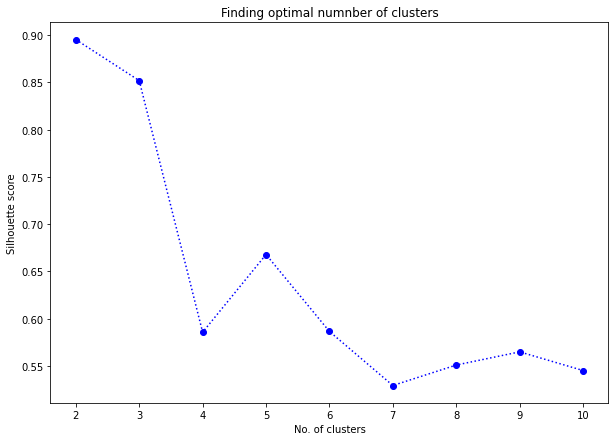

In [597]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(range(2, max_k+1),sil_scores,color='b', marker='o', linestyle=':')
ax.set_title('Finding optimal numnber of clusters')
ax.set_xlabel('No. of clusters')
ax.set_ylabel('Silhouette score')
plt.show()

In [598]:
# find optimal clusters
idx = np.argmax(sil_scores)
opt_clusters = num_clusters[idx]
opt_clusters

2

In [599]:
delivery_locs[["geo_latitude","geo_longitude"]]

,geo_latitude,geo_longitude
0,30.05057,31.17724
1,29.98978,31.18042
2,30.02172,31.24150
3,29.98319,31.32008
4,30.12215,31.29925
...,...,...
78,30.14204,31.24666
79,29.97530,31.14930
80,30.08516,31.20347
81,31.24145,30.13690


In [600]:
# refitting k-means with opt_clusters
model = cluster.KMeans(n_clusters=opt_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)


In [601]:
model.fit(X)
cluster_labels = model.predict(X)

In [602]:
cluster_labels = model.predict(X)

In [603]:
cluster_centers = np.degrees(model.cluster_centers_)
cluster_centers

array([[30.0479108 , 31.217954  ],
       [31.26979875, 30.11361375]])

In [604]:
delivery_locs[["geo_latitude","geo_longitude"]]

,geo_latitude,geo_longitude
0,30.05057,31.17724
1,29.98978,31.18042
2,30.02172,31.24150
3,29.98319,31.32008
4,30.12215,31.29925
...,...,...
78,30.14204,31.24666
79,29.97530,31.14930
80,30.08516,31.20347
81,31.24145,30.13690


In [605]:
delivery_locs['cluster_labels'] = cluster_labels

C:\Users\hassan.javed\AppData\Local\Temp\ipykernel_35792\3950026448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_locs['cluster_labels'] = cluster_labels


In [606]:
# K-means is not the right clustering model for this problem. It assumes spherical clusters of same size and thus it 
# misses one cluster here if we go by silhouette score  

### 2. Optimal no. of trucks

#### 2.1 Preparing data

##### 2.1.1 Calculating truck types and volumes

In [607]:
trucks


,truck_ID,length,width,height
0,1,230,170,165
1,2,230,170,165
2,3,230,170,165
3,4,200,100,115


In [608]:
# available trucks
avail_trucks = len(np.unique(trucks.truck_ID))
avail_trucks


4

In [609]:
# getting truck volumes
trucks['volume'] = trucks.length * trucks.width * trucks.height
trucks


,truck_ID,length,width,height,volume
0,1,230,170,165,6451500
1,2,230,170,165,6451500
2,3,230,170,165,6451500
3,4,200,100,115,2300000


In [610]:
# truck groups
truck_groups = trucks.groupby('volume').size()
truck_groups

volume
2300000    1
6451500    3
dtype: int64

In [611]:
# unique truck types
truck_types = trucks.groupby('volume').ngroups
truck_types

2

In [612]:
# truck type volumes
truck_vol = np.array(list(trucks.groupby('volume').groups.keys()))
truck_vol

array([2300000, 6451500])

In [613]:
truck_type_counts = truck_groups.values
truck_type_counts

array([1, 3], dtype=int64)

##### 2.1.2 Calculating order volumes by joining orders with items

In [614]:
# Joining orders data with items data
orders


,Order_ID,item_id,customer_id,Order_date,total_ITem_amount,requested_quantity
0,ORD-3880388,226,34506,2020-09-21,94.0,1
1,ORD-3880388,223,34506,2020-09-21,94.0,1
2,ORD-3880388,634,34506,2020-09-21,233.0,1
3,ORD-3880388,25,34506,2020-09-21,119.0,2
4,ORD-3880388,56,34506,2020-09-21,119.0,1
...,...,...,...,...,...,...
623,ORD-6026834,1375,7122,2020-09-22,87.0,1
624,ORD-6026834,249,7122,2020-09-22,55.5,3
625,ORD-6026834,389,7122,2020-09-22,70.0,1
626,ORD-6026834,136,7122,2020-09-22,681.5,10


In [615]:

items


,item_id,length,width,height
0,226,17.0,40.0,33.0
1,223,16.0,34.0,34.0
2,634,15.0,43.0,30.0
3,25,16.0,34.0,30.0
4,56,16.0,38.5,29.5
...,...,...,...,...
623,1375,34.5,33.0,39.5
624,249,20.0,33.0,26.0
625,389,27.0,31.0,21.0
626,136,24.0,46.0,12.0


In [616]:
# inspecting duplicate observations in items
items[items.duplicated()].sort_values(by='item_id')


,item_id,length,width,height
449,12,18.5,34.0,26.0
165,12,18.5,34.0,26.0
241,12,18.5,34.0,26.0
580,12,18.5,34.0,26.0
159,12,18.5,34.0,26.0
...,...,...,...,...
502,1342,35.0,35.0,45.0
613,1342,35.0,35.0,45.0
577,1381,20.0,34.5,18.5
431,1384,15.0,21.5,31.5


In [617]:
# dropping duplicates from items
items = items.drop_duplicates(subset=None, keep='first', ignore_index=True)
items.duplicated(subset='item_id').sum()


0

In [618]:
# inspecting null values in items
items.isna().sum()


item_id     0
length     10
width      10
height     10
dtype: int64

In [619]:
# dropping nulls from items where L,W,H are null
items = items.dropna(subset=['length', 'width', 'height'])
items.isna().sum()


item_id    0
length     0
width      0
height     0
dtype: int64

In [620]:
items

,item_id,length,width,height
0,226,17.0,40.0,33.0
1,223,16.0,34.0,34.0
2,634,15.0,43.0,30.0
3,25,16.0,34.0,30.0
4,56,16.0,38.5,29.5
...,...,...,...,...
231,744,22.0,51.0,20.5
232,349,13.0,37.0,17.0
233,758,9.0,28.0,5.0
234,1375,34.5,33.0,39.5


In [621]:
orders

,Order_ID,item_id,customer_id,Order_date,total_ITem_amount,requested_quantity
0,ORD-3880388,226,34506,2020-09-21,94.0,1
1,ORD-3880388,223,34506,2020-09-21,94.0,1
2,ORD-3880388,634,34506,2020-09-21,233.0,1
3,ORD-3880388,25,34506,2020-09-21,119.0,2
4,ORD-3880388,56,34506,2020-09-21,119.0,1
...,...,...,...,...,...,...
623,ORD-6026834,1375,7122,2020-09-22,87.0,1
624,ORD-6026834,249,7122,2020-09-22,55.5,3
625,ORD-6026834,389,7122,2020-09-22,70.0,1
626,ORD-6026834,136,7122,2020-09-22,681.5,10


In [622]:
# taking a left join of orders with items
orders_items = pd.merge(orders, items, on='item_id', how='left', validate='m:1').copy()
orders_items


,Order_ID,item_id,customer_id,Order_date,total_ITem_amount,requested_quantity,length,width,height
0,ORD-3880388,226,34506,2020-09-21,94.0,1,17.0,40.0,33.0
1,ORD-3880388,223,34506,2020-09-21,94.0,1,16.0,34.0,34.0
2,ORD-3880388,634,34506,2020-09-21,233.0,1,15.0,43.0,30.0
3,ORD-3880388,25,34506,2020-09-21,119.0,2,16.0,34.0,30.0
4,ORD-3880388,56,34506,2020-09-21,119.0,1,16.0,38.5,29.5
...,...,...,...,...,...,...,...,...,...
623,ORD-6026834,1375,7122,2020-09-22,87.0,1,34.5,33.0,39.5
624,ORD-6026834,249,7122,2020-09-22,55.5,3,20.0,33.0,26.0
625,ORD-6026834,389,7122,2020-09-22,70.0,1,27.0,31.0,21.0
626,ORD-6026834,136,7122,2020-09-22,681.5,10,24.0,46.0,12.0


In [623]:

orders_items.isna().sum()


Order_ID               0
item_id                0
customer_id            0
Order_date             0
total_ITem_amount      0
requested_quantity     0
length                14
width                 14
height                14
dtype: int64

In [624]:
orders_items = orders_items.dropna()
orders_items.isna().sum()


Order_ID              0
item_id               0
customer_id           0
Order_date            0
total_ITem_amount     0
requested_quantity    0
length                0
width                 0
height                0
dtype: int64

In [625]:
# calculating volume for each item
orders_items['volume'] =  orders_items.length * orders_items.width * orders_items.height
orders_items


C:\Users\hassan.javed\AppData\Local\Temp\ipykernel_35792\2269204837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_items['volume'] =  orders_items.length * orders_items.width * orders_items.height


,Order_ID,item_id,customer_id,Order_date,total_ITem_amount,requested_quantity,length,width,height,volume
0,ORD-3880388,226,34506,2020-09-21,94.0,1,17.0,40.0,33.0,22440.00
1,ORD-3880388,223,34506,2020-09-21,94.0,1,16.0,34.0,34.0,18496.00
2,ORD-3880388,634,34506,2020-09-21,233.0,1,15.0,43.0,30.0,19350.00
3,ORD-3880388,25,34506,2020-09-21,119.0,2,16.0,34.0,30.0,16320.00
4,ORD-3880388,56,34506,2020-09-21,119.0,1,16.0,38.5,29.5,18172.00
...,...,...,...,...,...,...,...,...,...,...
623,ORD-6026834,1375,7122,2020-09-22,87.0,1,34.5,33.0,39.5,44970.75
624,ORD-6026834,249,7122,2020-09-22,55.5,3,20.0,33.0,26.0,17160.00
625,ORD-6026834,389,7122,2020-09-22,70.0,1,27.0,31.0,21.0,17577.00
626,ORD-6026834,136,7122,2020-09-22,681.5,10,24.0,46.0,12.0,13248.00


In [626]:
# grouping items into orders
orders_vol = orders_items.groupby(['Order_ID','customer_id']).agg({'volume':'sum'}).reset_index()
orders_vol


,Order_ID,customer_id,volume
0,ORD-1020409,35267,51222.50
1,ORD-1141776,14040,80252.50
2,ORD-1301689,33713,478254.50
3,ORD-1393103,8651,187122.00
4,ORD-1447411,25591,14400.00
...,...,...,...
81,ORD-9484807,35031,4490.00
82,ORD-9553962,15812,94983.00
83,ORD-9583823,17148,239539.75
84,ORD-9716116,34868,17820.00


##### 2.1.3 Joining order volumes with delivery locations

In [627]:
orders_vol_locs = pd.merge(orders_vol, delivery_locs, on='Order_ID', how='inner', validate='1:1')
orders_vol_locs

,Order_ID,customer_id_x,volume,customer_id_y,buyer_business_type,district_id,district_name_ar,city_name_en,area_name_ar,geo_latitude,geo_longitude,registration_date,avg_ticket_size,number_of_transactions,number_of_cancelled_transactions,last_order_date,total_orders_amount,cluster_labels
0,ORD-1020409,35267,51222.50,35267,عطارة,100125.0,حلوان,Cairo,NaN,29.84684,31.33473,2020-10-31,NaN,NaN,NaN,NaN,NaN,0
1,ORD-1141776,14040,80252.50,14040,سوبر ماركت,100119.0,فيصل,Giza,المريوطيه,29.99936,31.14383,2020-05-07,2536.815,4.0,2.0,2021-03-05,10147.26,0
2,ORD-1301689,33713,478254.50,33713,قهوه,100128.0,المعادي,Cairo,NaN,29.98621,31.24994,2020-10-26,NaN,NaN,NaN,NaN,NaN,0
3,ORD-1393103,8651,187122.00,8651,سوبر ماركت,100152.0,مدينة السلام,Cairo,السلام,31.20126,30.08737,2020-06-07,1224.510,1.0,1.0,2020-09-23,1224.51,1
4,ORD-1447411,25591,14400.00,25591,منظفات,100123.0,الهرم,Giza,الهرم,29.99941,31.19241,2020-09-29,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,ORD-9239489,32765,151473.00,32765,كشك,100157.0,بولاق الدكرور,Giza,NaN,30.02815,31.20284,2020-10-24,NaN,NaN,NaN,NaN,NaN,0
62,ORD-9363122,19445,135726.50,19445,سوبر ماركت,100123.0,الهرم,Giza,الهرم,29.99749,31.17249,2020-08-19,260.000,1.0,0.0,2020-09-16,260.00,0
63,ORD-9553962,15812,94983.00,15812,سوبر ماركت,100179.0,بشتيل,Giza,بشتيل,31.22714,30.09738,2020-06-11,1190.140,2.0,0.0,2021-03-11,2380.28,1
64,ORD-9583823,17148,239539.75,17148,سوبر ماركت,100151.0,عزبة النخل,Cairo,عزبة النخل,30.14405,31.32775,2020-07-22,892.126,5.0,3.0,2020-09-29,4460.63,0


##### 2.1.4 Cluster wise total volumes to be delivered

In [628]:
temp = orders_vol_locs.dropna(subset=['area_name_ar'])
temp[temp.cluster_labels == 0].volume.sum()

5360230.0

In [629]:
cluster_vols = orders_vol_locs.groupby('cluster_labels').agg({'volume':'sum'}).reset_index()
cluster_vols

,cluster_labels,volume
0,0,8287553.500
1,1,1735394.625


In [630]:
tot_vol_clust_0 = cluster_vols[cluster_vols.cluster_labels==0].volume.values[0]
tot_vol_clust_0

8287553.5

In [631]:
tot_vol_clust_1 = cluster_vols[cluster_vols.cluster_labels==1].volume.values[0]
tot_vol_clust_1

1735394.625

#### 2.2 Truck loading model

In [632]:
print('Total no. of location clusters: ', opt_clusters)
print('Total number of available trucks: ', avail_trucks)
print('Total truck types: ', truck_types)
print('Total type counts: ', truck_type_counts)
print('Truck vol: ', truck_vol)

Total no. of location clusters:  2
Total number of available trucks:  4
Total truck types:  2
Total type counts:  [1 3]
Truck vol:  [2300000 6451500]


In [633]:
# defining an LP model
model = LpProblem('Minimize_Trucks', LpMinimize)


In [634]:
# defining decision variables
# since, there are two clusters, we'll build a model to minimize
# the number of the two types of trucks for each cluster
# n1c1 denotes number of vehicles of type 1 in cluster 1
n1c0 = LpVariable('n1c0', lowBound=0, cat='Integer')
n2c0 = LpVariable('n2c0', lowBound=0, cat='Integer')
n1c1 = LpVariable('n1c1', lowBound=0, cat='Integer')
n2c1 = LpVariable('n2c1', lowBound=0, cat='Integer')

In [635]:
# defining objective i.e. total number of trucks against each cluster
model += n1c0 + n2c0 + n1c1 + n2c1

In [636]:
# defining constraints I

# total allocated trucks of each type should be <= available no. of trucks
model += n1c0 + n1c1 <= truck_type_counts[0]
model += n2c0 + n2c1 <= truck_type_counts[1]


In [637]:
# defining constraints II

# allocated trucks to each cluster should have enough capacity for the cluster
var_dict = {0: [n1c0,n2c0], 1:[n1c1,n2c1]}
clust_vol = [tot_vol_clust_0, tot_vol_clust_1]

model += np.array(var_dict[0]).dot(truck_vol) >= clust_vol[0]
model += np.array(var_dict[1]).dot(truck_vol) >= clust_vol[1]

In [638]:
# solve model
model.solve()
trucks_num = {}
for clst in range(2):
    print('Number of trucks with volume {} in cluster {} : '.format(truck_vol[0],clst), var_dict[clst][0].varValue)
    print('Number of trucks with volume {} in cluster {} : '.format(truck_vol[1],clst), var_dict[clst][1].varValue)
    trucks_num[clst] = {truck_vol[0]:var_dict[clst][0].varValue, truck_vol[1]:var_dict[clst][1].varValue}
    print('************************')

Number of trucks with volume 2300000 in cluster 0 :  0.0
Number of trucks with volume 6451500 in cluster 0 :  2.0
************************
Number of trucks with volume 2300000 in cluster 1 :  0.0
Number of trucks with volume 6451500 in cluster 1 :  1.0
************************


In [639]:
# number of trucks per cluster
trucks_num

{0: {2300000: 0.0, 6451500: 2.0}, 1: {2300000: 0.0, 6451500: 1.0}}

In [640]:
# Sanity checking the solutions
for clst in range(2):
    total_truck_vol = var_dict[clst][0].varValue*truck_vol[0]+var_dict[clst][1].varValue*truck_vol[1]
    print('Total volume of allocated trucks for cluster {} is {} against total cluster {} volume {} : '\
        .format(clst, total_truck_vol, clst, clust_vol[clst]), total_truck_vol >= clust_vol[clst])
    print('************************')
    

Total volume of allocated trucks for cluster 0 is 12903000.0 against total cluster 0 volume 8287553.5 :  True
************************
Total volume of allocated trucks for cluster 1 is 6451500.0 against total cluster 1 volume 1735394.625 :  True
************************


### 3. Packing and routing model

#### 3.1 Preparing data 

In [641]:
# Vehicle routing is a generalization of a travelling salesperson problem
# We will use a nearest neighbour heuristic to solve the vehicle routing problem.
# Since, we already have solved for the no. of trucks, once we know the routes we'll
# fill the trucks with the loads accordingly


In [642]:
# to get paths through known areas, dropping null area names
# orders_vol_locs = orders_vol_locs.dropna(subset='area_name_ar')
orders_vol_locs = orders_vol_locs.fillna({'area_name_ar':'unknown'})

In [643]:
# grouping by area_name_ar

In [644]:
# create a distance matrix
c0_locs = orders_vol_locs[orders_vol_locs.cluster_labels == 0]
c1_locs = orders_vol_locs[orders_vol_locs.cluster_labels == 1]


In [645]:
# heaversine distance
def heaversine_dist(lat1, lon1, lat2, lon2):
    R = 6371e3 # metres
    phi1 = lat1 * math.pi/180
    phi2 = lat2 * math.pi/180
    del_phi = (lat2-lat1) * math.pi/180
    del_lambda = (lon2-lon1) * math.pi/180

    a = np.sin(del_phi/2) * np.sin(del_phi/2) +\
            np.cos(phi1) * np.cos(phi2) *\
            np.sin(del_lambda/2) * np.sin(del_lambda/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    d = (R * c)/1000 # in kilometres

    return d
    
# heaversine distance matrix
def heaversine_distmat(lats, lons):
    dists = np.zeros((len(lats),len(lats)))
    for i in np.arange(len(lats)):
        lat1, lon1 = lats[i], lons[i]
        d = heaversine_dist(lat1, lon1, lats, lons)
        dists[i,:] = d
    return dists
     

In [646]:

# calculate distance matrix  with heaversine
heaversine_dist(40.689202777778,-74.044219444444,38.889069444444,-77.034502777778)

324.53489135923655

In [647]:
distmat_c0 = heaversine_distmat(c0_locs.geo_latitude.values, c0_locs.geo_longitude.values)
distmat_c1 = heaversine_distmat(c1_locs.geo_latitude.values, c1_locs.geo_longitude.values)

In [648]:
df_distmat_c0 = pd.DataFrame(distmat_c0, columns=c0_locs.area_name_ar.values)
df_distmat_c0

,unknown,المريوطيه,unknown,الهرم,شبرا الخيمه,unknown,unknown,المعادي,unknown,شبرا الخيمة,...,unknown,unknown,unknown,unknown,الهرم,الزاويه الحمراء,unknown,الهرم,عزبة النخل,شبرا الخيمة
0,0.000000,25.021761,17.519841,21.815849,32.355125,25.022753,96.374046,15.990286,24.173362,33.902768,...,96.374046,1.540671,21.946065,24.287102,23.001554,28.705638,23.832045,22.914709,33.055079,34.330099
1,25.021761,0.000000,10.322968,4.678171,17.697145,0.484708,71.360065,10.554596,0.875378,18.698204,...,71.360065,24.280132,8.266613,23.784793,2.027011,16.456021,6.521537,2.767756,23.918130,18.247266
2,17.519841,10.322968,0.000000,5.731530,15.838979,10.602103,79.926273,1.890676,9.507934,17.330380,...,79.926273,17.296582,4.431866,15.087893,8.840428,12.683629,6.505169,7.563588,19.081611,17.521140
3,21.815849,4.678171,5.731530,0.000000,15.439843,5.017012,74.776118,6.296139,3.932788,16.696822,...,74.776118,21.287448,4.000127,19.357002,3.620702,13.366409,3.349817,1.930123,20.694964,16.511012
4,32.355125,17.697145,15.838979,15.439843,0.000000,18.178783,70.895086,17.720629,17.611364,1.548121,...,70.895086,32.460175,12.278082,14.482267,18.209209,3.792401,12.100384,16.428336,7.570155,2.241377
5,25.022753,0.484708,10.602103,5.017012,18.178783,0.000000,71.379454,10.759002,1.095633,19.175356,...,71.379454,24.254715,8.684034,24.202340,2.043165,16.938549,6.983139,3.089179,24.400654,18.718978
6,96.374046,71.360065,79.926273,74.776118,70.895086,71.379454,0.000000,80.989159,72.203282,69.790737,...,0.000000,95.634161,75.748904,85.375995,73.384653,74.182233,73.457907,73.502351,76.593745,68.747415
7,15.990286,10.554596,1.890676,6.296139,17.720629,10.759002,80.989159,0.000000,9.694234,19.207002,...,80.989159,15.671979,6.044254,16.370757,8.830320,14.572628,7.844474,7.899515,20.899020,19.380316
8,24.173362,0.875378,9.507934,3.932788,17.611364,1.095633,72.203282,9.694234,0.000000,18.668043,...,72.203282,23.445109,7.672997,23.180857,1.228794,16.190878,6.103307,2.002679,23.646592,18.266668
9,33.902768,18.698204,17.330380,16.696822,1.548121,19.175356,69.790737,19.207002,18.668043,0.000000,...,69.790737,34.004375,13.673905,15.646885,19.328865,5.310589,13.347377,17.586660,7.800697,1.129257


In [649]:
df_distmat_c1 = pd.DataFrame(distmat_c1, columns=c1_locs.area_name_ar.values)
df_distmat_c1

,السلام,شبرا الخيمة,عين شمس,شبرا الخيمة,المرج الجديدة,المرج الجديدة,unknown,شبرا الخيمة,شبرا الخيمة,المرج الجديدة,جسر السويس,صفط اللبن,المرج الجديدة,المرج الجديدة,شبرا الخيمة,بشتيل
0,0.000000,6.533015,12.423829,6.533015,16.471049,16.471049,10.972352,6.533015,6.658964,16.471049,7.117621,5.407183,16.471049,16.471049,6.492603,3.031084
1,6.533015,0.000000,6.740543,0.000000,10.052689,10.052689,4.548025,0.000000,9.792805,10.052689,11.571922,11.636037,10.052689,10.052689,1.565174,3.675084
2,12.423829,6.740543,0.000000,6.740543,5.119489,5.119489,3.241460,6.740543,12.474016,5.119489,14.837562,16.590243,5.119489,5.119489,7.997053,9.418965
3,6.533015,0.000000,6.740543,0.000000,10.052689,10.052689,4.548025,0.000000,9.792805,10.052689,11.571922,11.636037,10.052689,10.052689,1.565174,3.675084
4,16.471049,10.052689,5.119489,10.052689,0.000000,0.000000,5.512762,10.052689,17.493330,0.000000,19.810046,21.154001,0.000000,0.000000,10.741452,13.460446
5,16.471049,10.052689,5.119489,10.052689,0.000000,0.000000,5.512762,10.052689,17.493330,0.000000,19.810046,21.154001,0.000000,0.000000,10.741452,13.460446
6,10.972352,4.548025,3.241460,4.548025,5.512762,5.512762,0.000000,4.548025,12.751523,5.512762,14.911258,15.793948,5.512762,5.512762,5.392837,7.978931
7,6.533015,0.000000,6.740543,0.000000,10.052689,10.052689,4.548025,0.000000,9.792805,10.052689,11.571922,11.636037,10.052689,10.052689,1.565174,3.675084
8,6.658964,9.792805,12.474016,9.792805,17.493330,17.493330,12.751523,9.792805,0.000000,17.493330,2.435410,5.960828,17.493330,17.493330,10.750744,6.894777
9,16.471049,10.052689,5.119489,10.052689,0.000000,0.000000,5.512762,10.052689,17.493330,0.000000,19.810046,21.154001,0.000000,0.000000,10.741452,13.460446


In [650]:
# duplicate columns renaming
# An incrementer
import itertools
inc = itertools.count().__next__

# A renamer
def ren(name):
    return f"{name}_{inc()}" if name not in excluded else name

In [651]:
excluded = df_distmat_c0.columns[~df_distmat_c0.columns.duplicated(keep=False)]


In [652]:
inc = itertools.count().__next__
df_distmat_c0 = df_distmat_c0.rename(columns=ren)
df_distmat_c0

,unknown_0,المريوطيه,unknown_1,الهرم_2,شبرا الخيمه_3,unknown_4,unknown_5,المعادي_6,unknown_7,شبرا الخيمة_8,...,unknown_29,unknown_30,unknown_31,unknown_32,الهرم_33,الزاويه الحمراء,unknown_34,الهرم_35,عزبة النخل,شبرا الخيمة_36
0,0.000000,25.021761,17.519841,21.815849,32.355125,25.022753,96.374046,15.990286,24.173362,33.902768,...,96.374046,1.540671,21.946065,24.287102,23.001554,28.705638,23.832045,22.914709,33.055079,34.330099
1,25.021761,0.000000,10.322968,4.678171,17.697145,0.484708,71.360065,10.554596,0.875378,18.698204,...,71.360065,24.280132,8.266613,23.784793,2.027011,16.456021,6.521537,2.767756,23.918130,18.247266
2,17.519841,10.322968,0.000000,5.731530,15.838979,10.602103,79.926273,1.890676,9.507934,17.330380,...,79.926273,17.296582,4.431866,15.087893,8.840428,12.683629,6.505169,7.563588,19.081611,17.521140
3,21.815849,4.678171,5.731530,0.000000,15.439843,5.017012,74.776118,6.296139,3.932788,16.696822,...,74.776118,21.287448,4.000127,19.357002,3.620702,13.366409,3.349817,1.930123,20.694964,16.511012
4,32.355125,17.697145,15.838979,15.439843,0.000000,18.178783,70.895086,17.720629,17.611364,1.548121,...,70.895086,32.460175,12.278082,14.482267,18.209209,3.792401,12.100384,16.428336,7.570155,2.241377
5,25.022753,0.484708,10.602103,5.017012,18.178783,0.000000,71.379454,10.759002,1.095633,19.175356,...,71.379454,24.254715,8.684034,24.202340,2.043165,16.938549,6.983139,3.089179,24.400654,18.718978
6,96.374046,71.360065,79.926273,74.776118,70.895086,71.379454,0.000000,80.989159,72.203282,69.790737,...,0.000000,95.634161,75.748904,85.375995,73.384653,74.182233,73.457907,73.502351,76.593745,68.747415
7,15.990286,10.554596,1.890676,6.296139,17.720629,10.759002,80.989159,0.000000,9.694234,19.207002,...,80.989159,15.671979,6.044254,16.370757,8.830320,14.572628,7.844474,7.899515,20.899020,19.380316
8,24.173362,0.875378,9.507934,3.932788,17.611364,1.095633,72.203282,9.694234,0.000000,18.668043,...,72.203282,23.445109,7.672997,23.180857,1.228794,16.190878,6.103307,2.002679,23.646592,18.266668
9,33.902768,18.698204,17.330380,16.696822,1.548121,19.175356,69.790737,19.207002,18.668043,0.000000,...,69.790737,34.004375,13.673905,15.646885,19.328865,5.310589,13.347377,17.586660,7.800697,1.129257


In [653]:
excluded = df_distmat_c1.columns[~df_distmat_c1.columns.duplicated(keep=False)]
inc = itertools.count().__next__
df_distmat_c1 = df_distmat_c1.rename(columns=ren)
df_distmat_c1

,السلام,شبرا الخيمة_0,عين شمس,شبرا الخيمة_1,المرج الجديدة_2,المرج الجديدة_3,unknown,شبرا الخيمة_4,شبرا الخيمة_5,المرج الجديدة_6,جسر السويس,صفط اللبن,المرج الجديدة_7,المرج الجديدة_8,شبرا الخيمة_9,بشتيل
0,0.000000,6.533015,12.423829,6.533015,16.471049,16.471049,10.972352,6.533015,6.658964,16.471049,7.117621,5.407183,16.471049,16.471049,6.492603,3.031084
1,6.533015,0.000000,6.740543,0.000000,10.052689,10.052689,4.548025,0.000000,9.792805,10.052689,11.571922,11.636037,10.052689,10.052689,1.565174,3.675084
2,12.423829,6.740543,0.000000,6.740543,5.119489,5.119489,3.241460,6.740543,12.474016,5.119489,14.837562,16.590243,5.119489,5.119489,7.997053,9.418965
3,6.533015,0.000000,6.740543,0.000000,10.052689,10.052689,4.548025,0.000000,9.792805,10.052689,11.571922,11.636037,10.052689,10.052689,1.565174,3.675084
4,16.471049,10.052689,5.119489,10.052689,0.000000,0.000000,5.512762,10.052689,17.493330,0.000000,19.810046,21.154001,0.000000,0.000000,10.741452,13.460446
5,16.471049,10.052689,5.119489,10.052689,0.000000,0.000000,5.512762,10.052689,17.493330,0.000000,19.810046,21.154001,0.000000,0.000000,10.741452,13.460446
6,10.972352,4.548025,3.241460,4.548025,5.512762,5.512762,0.000000,4.548025,12.751523,5.512762,14.911258,15.793948,5.512762,5.512762,5.392837,7.978931
7,6.533015,0.000000,6.740543,0.000000,10.052689,10.052689,4.548025,0.000000,9.792805,10.052689,11.571922,11.636037,10.052689,10.052689,1.565174,3.675084
8,6.658964,9.792805,12.474016,9.792805,17.493330,17.493330,12.751523,9.792805,0.000000,17.493330,2.435410,5.960828,17.493330,17.493330,10.750744,6.894777
9,16.471049,10.052689,5.119489,10.052689,0.000000,0.000000,5.512762,10.052689,17.493330,0.000000,19.810046,21.154001,0.000000,0.000000,10.741452,13.460446


In [654]:
# set row indices to be equal to the columns
df_distmat_c0.index = df_distmat_c0.columns
df_distmat_c0 

,unknown_0,المريوطيه,unknown_1,الهرم_2,شبرا الخيمه_3,unknown_4,unknown_5,المعادي_6,unknown_7,شبرا الخيمة_8,...,unknown_29,unknown_30,unknown_31,unknown_32,الهرم_33,الزاويه الحمراء,unknown_34,الهرم_35,عزبة النخل,شبرا الخيمة_36
unknown_0,0.000000,25.021761,17.519841,21.815849,32.355125,25.022753,96.374046,15.990286,24.173362,33.902768,...,96.374046,1.540671,21.946065,24.287102,23.001554,28.705638,23.832045,22.914709,33.055079,34.330099
المريوطيه,25.021761,0.000000,10.322968,4.678171,17.697145,0.484708,71.360065,10.554596,0.875378,18.698204,...,71.360065,24.280132,8.266613,23.784793,2.027011,16.456021,6.521537,2.767756,23.918130,18.247266
unknown_1,17.519841,10.322968,0.000000,5.731530,15.838979,10.602103,79.926273,1.890676,9.507934,17.330380,...,79.926273,17.296582,4.431866,15.087893,8.840428,12.683629,6.505169,7.563588,19.081611,17.521140
الهرم_2,21.815849,4.678171,5.731530,0.000000,15.439843,5.017012,74.776118,6.296139,3.932788,16.696822,...,74.776118,21.287448,4.000127,19.357002,3.620702,13.366409,3.349817,1.930123,20.694964,16.511012
شبرا الخيمه_3,32.355125,17.697145,15.838979,15.439843,0.000000,18.178783,70.895086,17.720629,17.611364,1.548121,...,70.895086,32.460175,12.278082,14.482267,18.209209,3.792401,12.100384,16.428336,7.570155,2.241377
unknown_4,25.022753,0.484708,10.602103,5.017012,18.178783,0.000000,71.379454,10.759002,1.095633,19.175356,...,71.379454,24.254715,8.684034,24.202340,2.043165,16.938549,6.983139,3.089179,24.400654,18.718978
unknown_5,96.374046,71.360065,79.926273,74.776118,70.895086,71.379454,0.000000,80.989159,72.203282,69.790737,...,0.000000,95.634161,75.748904,85.375995,73.384653,74.182233,73.457907,73.502351,76.593745,68.747415
المعادي_6,15.990286,10.554596,1.890676,6.296139,17.720629,10.759002,80.989159,0.000000,9.694234,19.207002,...,80.989159,15.671979,6.044254,16.370757,8.830320,14.572628,7.844474,7.899515,20.899020,19.380316
unknown_7,24.173362,0.875378,9.507934,3.932788,17.611364,1.095633,72.203282,9.694234,0.000000,18.668043,...,72.203282,23.445109,7.672997,23.180857,1.228794,16.190878,6.103307,2.002679,23.646592,18.266668
شبرا الخيمة_8,33.902768,18.698204,17.330380,16.696822,1.548121,19.175356,69.790737,19.207002,18.668043,0.000000,...,69.790737,34.004375,13.673905,15.646885,19.328865,5.310589,13.347377,17.586660,7.800697,1.129257


In [655]:
df_distmat_c1.index = df_distmat_c1.columns
df_distmat_c1 

,السلام,شبرا الخيمة_0,عين شمس,شبرا الخيمة_1,المرج الجديدة_2,المرج الجديدة_3,unknown,شبرا الخيمة_4,شبرا الخيمة_5,المرج الجديدة_6,جسر السويس,صفط اللبن,المرج الجديدة_7,المرج الجديدة_8,شبرا الخيمة_9,بشتيل
السلام,0.000000,6.533015,12.423829,6.533015,16.471049,16.471049,10.972352,6.533015,6.658964,16.471049,7.117621,5.407183,16.471049,16.471049,6.492603,3.031084
شبرا الخيمة_0,6.533015,0.000000,6.740543,0.000000,10.052689,10.052689,4.548025,0.000000,9.792805,10.052689,11.571922,11.636037,10.052689,10.052689,1.565174,3.675084
عين شمس,12.423829,6.740543,0.000000,6.740543,5.119489,5.119489,3.241460,6.740543,12.474016,5.119489,14.837562,16.590243,5.119489,5.119489,7.997053,9.418965
شبرا الخيمة_1,6.533015,0.000000,6.740543,0.000000,10.052689,10.052689,4.548025,0.000000,9.792805,10.052689,11.571922,11.636037,10.052689,10.052689,1.565174,3.675084
المرج الجديدة_2,16.471049,10.052689,5.119489,10.052689,0.000000,0.000000,5.512762,10.052689,17.493330,0.000000,19.810046,21.154001,0.000000,0.000000,10.741452,13.460446
المرج الجديدة_3,16.471049,10.052689,5.119489,10.052689,0.000000,0.000000,5.512762,10.052689,17.493330,0.000000,19.810046,21.154001,0.000000,0.000000,10.741452,13.460446
unknown,10.972352,4.548025,3.241460,4.548025,5.512762,5.512762,0.000000,4.548025,12.751523,5.512762,14.911258,15.793948,5.512762,5.512762,5.392837,7.978931
شبرا الخيمة_4,6.533015,0.000000,6.740543,0.000000,10.052689,10.052689,4.548025,0.000000,9.792805,10.052689,11.571922,11.636037,10.052689,10.052689,1.565174,3.675084
شبرا الخيمة_5,6.658964,9.792805,12.474016,9.792805,17.493330,17.493330,12.751523,9.792805,0.000000,17.493330,2.435410,5.960828,17.493330,17.493330,10.750744,6.894777
المرج الجديدة_6,16.471049,10.052689,5.119489,10.052689,0.000000,0.000000,5.512762,10.052689,17.493330,0.000000,19.810046,21.154001,0.000000,0.000000,10.741452,13.460446


In [656]:
c0_vols_locs = pd.DataFrame([c0_locs.volume.tolist(), c0_locs.geo_latitude, c0_locs.geo_longitude], columns=c0_locs.area_name_ar.tolist())
excluded = c0_vols_locs.columns[~c0_vols_locs.columns.duplicated(keep=False)]
inc = itertools.count().__next__
c0_vols_locs = c0_vols_locs.rename(columns=ren)
c0_vols_locs =  c0_vols_locs.T.reset_index()
c0_vols_locs.columns = ['area_name_ar','volume', 'geo_latitude', 'geo_longitude']
c0_vols_locs 

,area_name_ar,volume,geo_latitude,geo_longitude
0,unknown_0,51222.500,29.84684,31.33473
1,المريوطيه,80252.500,29.99936,31.14383
2,unknown_1,478254.500,29.98621,31.24994
3,الهرم_2,14400.000,29.99941,31.19241
4,شبرا الخيمه_3,128022.500,30.12865,31.25107
5,unknown_4,217732.000,29.99613,31.14045
6,unknown_5,16354.000,30.44637,30.61092
7,المعادي_6,32975.000,29.96931,31.24778
8,unknown_7,204214.500,29.99559,31.15181
9,شبرا الخيمة_8,196062.500,30.14204,31.24666


In [657]:
c1_vols_locs = pd.DataFrame([c1_locs.volume.tolist(), c1_locs.geo_latitude, c1_locs.geo_longitude], columns=c1_locs.area_name_ar.tolist())
excluded = c1_vols_locs.columns[~c1_vols_locs.columns.duplicated(keep=False)]
inc = itertools.count().__next__
c1_vols_locs = c1_vols_locs.rename(columns=ren)
c1_vols_locs =  c1_vols_locs.T.reset_index()
c1_vols_locs.columns = ['area_name_ar','volume', 'geo_latitude', 'geo_longitude']
c1_vols_locs

,area_name_ar,volume,geo_latitude,geo_longitude
0,السلام,187122.000,31.20126,30.08737
1,شبرا الخيمة_0,14950.000,31.25070,30.12449
2,عين شمس,104424.000,31.31065,30.11398
3,شبرا الخيمة_1,17820.000,31.25070,30.12449
4,المرج الجديدة_2,8330.000,31.33622,30.15880
5,المرج الجديدة_3,34738.500,31.33622,30.15880
6,unknown,143409.250,31.28994,30.13799
7,شبرا الخيمة_4,8177.000,31.25070,30.12449
8,شبرا الخيمة_5,247776.750,31.22828,30.02488
9,المرج الجديدة_6,73164.750,31.33622,30.15880


In [658]:
cluster_centers

array([[30.0479108 , 31.217954  ],
       [31.26979875, 30.11361375]])

In [659]:
# Get starting position for each cluster's route i.e. the farthest point at the boundary\
# of each cluster This heuristic for the start point is for the sake of example only. 
# In real applications, we would choose a real location as a starting point 


In [660]:
c0_center = cluster_centers[0,:]
c1_center = cluster_centers[1,:]

In [661]:
c0_start_idx = np.argmax(heaversine_dist(c0_center[0], c0_center[1],\
     c0_locs.geo_latitude.values, c0_locs.geo_longitude.values))
c0_start = c0_locs.loc[c0_start_idx,'area_name_ar']
print('Cluster 0 start is at: ',c0_start)
c1_start_idx = np.argmax(heaversine_dist(c1_center[0], c1_center[1],\
     c1_locs.geo_latitude.values, c1_locs.geo_longitude.values))
c1_start = c1_locs.loc[c1_start_idx,'area_name_ar']
print('Cluster 1 start is at: ',c1_start)

Cluster 0 start is at:  unknown
Cluster 1 start is at:  شبرا الخيمة


In [734]:
# get route start function

def get_route_start(c_center, c_locs):
    c_start_idx = np.argmax(heaversine_dist(c_center[0], c_center[1],\
    c_locs.geo_latitude.values, c_locs.geo_longitude.values))
    c_start = c_locs['area_name_ar'].iloc[c_start_idx]
    return c_start

get_route_start(c0_center, c0_locs)



'unknown'

In [731]:
c0_locs

,Order_ID,customer_id_x,volume,customer_id_y,buyer_business_type,district_id,district_name_ar,city_name_en,area_name_ar,geo_latitude,geo_longitude,registration_date,avg_ticket_size,number_of_transactions,number_of_cancelled_transactions,last_order_date,total_orders_amount,cluster_labels
0,ORD-1020409,35267,51222.500,35267,عطارة,100125.0,حلوان,Cairo,unknown,29.84684,31.33473,2020-10-31,NaN,NaN,NaN,NaN,NaN,0
1,ORD-1141776,14040,80252.500,14040,سوبر ماركت,100119.0,فيصل,Giza,المريوطيه,29.99936,31.14383,2020-05-07,2536.815000,4.0,2.0,2021-03-05,10147.26,0
2,ORD-1301689,33713,478254.500,33713,قهوه,100128.0,المعادي,Cairo,unknown,29.98621,31.24994,2020-10-26,NaN,NaN,NaN,NaN,NaN,0
4,ORD-1447411,25591,14400.000,25591,منظفات,100123.0,الهرم,Giza,الهرم,29.99941,31.19241,2020-09-29,NaN,NaN,NaN,NaN,NaN,0
5,ORD-1570425,32102,128022.500,32102,سوبر ماركت,100184.0,شبرا الخيمه,Cairo,شبرا الخيمه,30.12865,31.25107,2020-10-22,651.400000,2.0,0.0,2021-02-24,1302.80,0
6,ORD-1684513,33212,217732.000,33212,سوبر ماركت,100119.0,فيصل,Giza,unknown,29.99613,31.14045,2020-10-25,510.090000,1.0,0.0,2020-10-25,510.09,0
7,ORD-1959770,33393,16354.000,33393,سوبر ماركت,100154.0,باسوس,Cairo,unknown,30.44637,30.61092,2020-10-26,NaN,NaN,NaN,NaN,NaN,0
9,ORD-2260065,17120,32975.000,17120,سوبر ماركت,100128.0,المعادي,Cairo,المعادي,29.96931,31.24778,2020-07-22,NaN,NaN,NaN,NaN,NaN,0
12,ORD-3110108,31179,204214.500,31179,اخري,100119.0,فيصل,Giza,unknown,29.99559,31.15181,2020-10-20,401.835000,4.0,3.0,2021-02-06,1607.34,0
13,ORD-3207369,17871,196062.500,17871,سوبر ماركت,100143.0,شبرا الخيمة,Cairo,شبرا الخيمة,30.14204,31.24666,2020-08-06,NaN,NaN,NaN,NaN,NaN,0


#### 3.2 Nearest neighbours model

##### 3.2.1 Single truck NN model

In [663]:

num_trucks_c0 = trucks_num[0]
num_trucks_c1 = trucks_num[1]


In [664]:
num_trucks_c1

{2300000: 0.0, 6451500: 1.0}

In [665]:
df_distmat_c1

,السلام,شبرا الخيمة_0,عين شمس,شبرا الخيمة_1,المرج الجديدة_2,المرج الجديدة_3,unknown,شبرا الخيمة_4,شبرا الخيمة_5,المرج الجديدة_6,جسر السويس,صفط اللبن,المرج الجديدة_7,المرج الجديدة_8,شبرا الخيمة_9,بشتيل
السلام,0.000000,6.533015,12.423829,6.533015,16.471049,16.471049,10.972352,6.533015,6.658964,16.471049,7.117621,5.407183,16.471049,16.471049,6.492603,3.031084
شبرا الخيمة_0,6.533015,0.000000,6.740543,0.000000,10.052689,10.052689,4.548025,0.000000,9.792805,10.052689,11.571922,11.636037,10.052689,10.052689,1.565174,3.675084
عين شمس,12.423829,6.740543,0.000000,6.740543,5.119489,5.119489,3.241460,6.740543,12.474016,5.119489,14.837562,16.590243,5.119489,5.119489,7.997053,9.418965
شبرا الخيمة_1,6.533015,0.000000,6.740543,0.000000,10.052689,10.052689,4.548025,0.000000,9.792805,10.052689,11.571922,11.636037,10.052689,10.052689,1.565174,3.675084
المرج الجديدة_2,16.471049,10.052689,5.119489,10.052689,0.000000,0.000000,5.512762,10.052689,17.493330,0.000000,19.810046,21.154001,0.000000,0.000000,10.741452,13.460446
المرج الجديدة_3,16.471049,10.052689,5.119489,10.052689,0.000000,0.000000,5.512762,10.052689,17.493330,0.000000,19.810046,21.154001,0.000000,0.000000,10.741452,13.460446
unknown,10.972352,4.548025,3.241460,4.548025,5.512762,5.512762,0.000000,4.548025,12.751523,5.512762,14.911258,15.793948,5.512762,5.512762,5.392837,7.978931
شبرا الخيمة_4,6.533015,0.000000,6.740543,0.000000,10.052689,10.052689,4.548025,0.000000,9.792805,10.052689,11.571922,11.636037,10.052689,10.052689,1.565174,3.675084
شبرا الخيمة_5,6.658964,9.792805,12.474016,9.792805,17.493330,17.493330,12.751523,9.792805,0.000000,17.493330,2.435410,5.960828,17.493330,17.493330,10.750744,6.894777
المرج الجديدة_6,16.471049,10.052689,5.119489,10.052689,0.000000,0.000000,5.512762,10.052689,17.493330,0.000000,19.810046,21.154001,0.000000,0.000000,10.741452,13.460446


In [821]:

# initializations
curr_loc = get_route_start(c0_center,c1_vols_locs)
dest_mat = df_distmat_c1.copy()
dests = dest_mat.columns.tolist()

route = []
dists = []
vols = []
curr_total_dist = 0
curr_total_volume = c1_vols_locs[c1_vols_locs.area_name_ar == curr_loc].volume.values[0]

In [822]:
c1_vols_locs

,area_name_ar,volume,geo_latitude,geo_longitude
0,السلام,187122.000,31.20126,30.08737
1,شبرا الخيمة_0,14950.000,31.25070,30.12449
2,عين شمس,104424.000,31.31065,30.11398
3,شبرا الخيمة_1,17820.000,31.25070,30.12449
4,المرج الجديدة_2,8330.000,31.33622,30.15880
5,المرج الجديدة_3,34738.500,31.33622,30.15880
6,unknown,143409.250,31.28994,30.13799
7,شبرا الخيمة_4,8177.000,31.25070,30.12449
8,شبرا الخيمة_5,247776.750,31.22828,30.02488
9,المرج الجديدة_6,73164.750,31.33622,30.15880


In [823]:
curr_total_volume

104424.0

In [824]:
c1_vols_locs

,area_name_ar,volume,geo_latitude,geo_longitude
0,السلام,187122.000,31.20126,30.08737
1,شبرا الخيمة_0,14950.000,31.25070,30.12449
2,عين شمس,104424.000,31.31065,30.11398
3,شبرا الخيمة_1,17820.000,31.25070,30.12449
4,المرج الجديدة_2,8330.000,31.33622,30.15880
5,المرج الجديدة_3,34738.500,31.33622,30.15880
6,unknown,143409.250,31.28994,30.13799
7,شبرا الخيمة_4,8177.000,31.25070,30.12449
8,شبرا الخيمة_5,247776.750,31.22828,30.02488
9,المرج الجديدة_6,73164.750,31.33622,30.15880


In [825]:

while dests:
    
    
    print(curr_loc)
    print(curr_total_volume)
    dists.append(curr_total_dist)
    vols.append(curr_total_volume)
    route.append(curr_loc)
    dests.remove(curr_loc)
    dest_mat = dest_mat.drop(curr_loc, axis=1)

    curr_row = dest_mat.loc[curr_loc,:]
    if not curr_row.empty:


        curr_loc = curr_row.index[curr_row.argmin()]
        curr_total_dist = curr_total_dist + curr_row.min()
        curr_total_volume = curr_total_volume + c1_vols_locs[c1_vols_locs.area_name_ar == curr_loc].volume.values[0]

print('Route is: ', route) 
print('Dists are: ', dists)
print('Vols are: ', vols)    


عين شمس
104424.0
unknown
247833.25
شبرا الخيمة_0
262783.25
شبرا الخيمة_1
280603.25
شبرا الخيمة_4
288780.25
شبرا الخيمة_9
431229.75
بشتيل
526212.75
السلام
713334.75
صفط اللبن
1022150.25
جسر السويس
1287818.625
شبرا الخيمة_5
1535595.375
المرج الجديدة_2
1543925.375
المرج الجديدة_3
1578663.875
المرج الجديدة_6
1651828.625
المرج الجديدة_7
1694794.625
المرج الجديدة_8
1735394.625
Route is:  ['عين شمس', 'unknown', 'شبرا الخيمة_0', 'شبرا الخيمة_1', 'شبرا الخيمة_4', 'شبرا الخيمة_9', 'بشتيل', 'السلام', 'صفط اللبن', 'جسر السويس', 'شبرا الخيمة_5', 'المرج الجديدة_2', 'المرج الجديدة_3', 'المرج الجديدة_6', 'المرج الجديدة_7', 'المرج الجديدة_8']
Dists are:  [0, 3.2414599213203252, 7.789484786321701, 7.789484786321701, 7.789484786321701, 9.3546592196963, 13.435160740436134, 16.466244683338463, 21.873427187055924, 26.269380672329802, 28.704790916440086, 46.198121100542544, 46.198121100542544, 46.198121100542544, 46.198121100542544, 46.198121100542544]
Vols are:  [104424.0, 247833.25, 262783.25, 280603.25, 2

In [826]:
route_dists_c1 = pd.DataFrame({'route':route,'dists':dists, 'volumes':vols })
route_dists_c1

,route,dists,volumes
0,عين شمس,0.000000,104424.000
1,unknown,3.241460,247833.250
2,شبرا الخيمة_0,7.789485,262783.250
3,شبرا الخيمة_1,7.789485,280603.250
4,شبرا الخيمة_4,7.789485,288780.250
5,شبرا الخيمة_9,9.354659,431229.750
6,بشتيل,13.435161,526212.750
7,السلام,16.466245,713334.750
8,صفط اللبن,21.873427,1022150.250
9,جسر السويس,26.269381,1287818.625


##### 3.2.2 Generalized NN model for k trucks of m different volumes

In [669]:
num_trucks_c0

{2300000: 0.0, 6451500: 2.0}

In [807]:
routes_df = pd.DataFrame()
route = []

In [808]:

for vol,trucks in num_trucks_c0.items():
    
    for tr in range(int(trucks)):
        print('truck', tr)
        print('volume', vol)
        
        dest_mat = df_distmat_c0.copy()
        dest_mat = dest_mat.loc[~dest_mat.columns.isin(route),~dest_mat.columns.isin(route)]
        dests = dest_mat.columns.tolist()
        c0_locs_dests = c0_vols_locs[c0_vols_locs.area_name_ar.isin(dests)]
        curr_loc = get_route_start(c0_center, c0_locs_dests)
        curr_volume = c0_vols_locs[c0_vols_locs.area_name_ar == curr_loc].volume.values[0]
        curr_total_volume = 0
        curr_total_dist = 0
        dists = []
        vols = []
        route = []

        
    
        while dests:
            
            curr_volume = c0_vols_locs[c0_vols_locs.area_name_ar == curr_loc].volume.values[0]
            if (curr_total_volume + curr_volume) < vol: 
                curr_total_volume = curr_total_volume + curr_volume
                dists.append(curr_total_dist)
                vols.append(curr_total_volume)
                route.append(curr_loc)
            dests.remove(curr_loc)
            dest_mat = dest_mat.drop(curr_loc, axis=1) 
            curr_row = dest_mat.loc[curr_loc,:]
            
            if not curr_row.empty:
                curr_loc = curr_row.index[curr_row.argmin()]
                curr_total_dist = curr_total_dist + curr_row.min()
                
        routes_df = pd.concat([routes_df,pd.DataFrame({'route':route, 'cum_vols':vols,\
             'cum_dists':dists,'truck_no':np.ones(len(route))*tr, 'truck_volume': \
                 np.ones(len(route))*vol})])

        print('Route is: ', route) 
        print('Dists are: ', dists)
        print('Vols are: ', vols)
        
                         


truck 0
volume 6451500
Route is:  ['unknown_5', 'unknown_29', 'شبرا الخيمة_36', 'شبرا الخيمه_20', 'شبرا الخيمة_8', 'شبرا الخيمه_12', 'شبرا الخيمه_3', 'ميدان العباسية', 'الزاويه الحمراء', 'ترعة الجبل', 'unknown_22', 'التروللى', 'عزبة النخل', 'شبرا الخيمة_17', 'السلام', 'unknown_32', 'مدينه نصر', 'المعادي_21', 'المعادي_9', 'المعادي_6', 'المعادي_25', 'unknown_1', 'السيدة زينب_16', 'unknown_31', 'مصر القديمة', 'unknown_34', 'ابو اتاته', 'unknown_18', 'الطوابق_14', 'الطوابق_28', 'unknown_7', 'المريوطيه', 'unknown_4', 'unknown_15', 'الهرم_33', 'نزلة السيسي', 'الهرم_35', 'الهرم_2', 'الهرم_27', 'المنيره']
Dists are:  [0, 0.0, 68.7474149878222, 69.34141563871977, 70.2884266077953, 71.43990054464751, 72.31279826757378, 72.96115100781007, 76.19760460504372, 79.65475001065771, 80.6766677739745, 82.33183874267795, 85.99817206677083, 88.32756240691407, 96.60109952235238, 110.56015873310056, 113.44411075940918, 123.16425074143609, 129.62918733018984, 130.6679964524626, 132.2167487072513, 133.06054040

In [809]:
routes_df

,route,cum_vols,cum_dists,truck_no,truck_volume
0,unknown_5,16354.000,0.000000,0.0,6451500.0
1,unknown_29,24400.500,0.000000,0.0,6451500.0
2,شبرا الخيمة_36,101359.000,68.747415,0.0,6451500.0
3,شبرا الخيمه_20,123319.000,69.341416,0.0,6451500.0
4,شبرا الخيمة_8,319381.500,70.288427,0.0,6451500.0
5,شبرا الخيمه_12,1263151.000,71.439901,0.0,6451500.0
6,شبرا الخيمه_3,1391173.500,72.312798,0.0,6451500.0
7,ميدان العباسية,1480155.500,72.961151,0.0,6451500.0
8,الزاويه الحمراء,1781440.375,76.197605,0.0,6451500.0
9,ترعة الجبل,2127392.125,79.654750,0.0,6451500.0


In [811]:
routes_df = pd.DataFrame()
route = []

In [812]:
for vol,trucks in num_trucks_c1.items():
    
    for tr in range(int(trucks)):
        print('truck', tr)
        print('volume', vol)
        
        dest_mat = df_distmat_c1.copy()
        dest_mat = dest_mat.loc[~dest_mat.columns.isin(route),~dest_mat.columns.isin(route)]
        dests = dest_mat.columns.tolist()
        c1_locs_dests = c1_vols_locs[c1_vols_locs.area_name_ar.isin(dests)]
        curr_loc = get_route_start(c1_center, c1_locs_dests)
        curr_volume = c1_vols_locs[c1_vols_locs.area_name_ar == curr_loc].volume.values[0]
        curr_total_volume = 0
        curr_total_dist = 0
        dists = []
        vols = []
        route = []

        
    
        while dests:
            
            curr_volume = c1_vols_locs[c1_vols_locs.area_name_ar == curr_loc].volume.values[0]
            if (curr_total_volume + curr_volume) < vol: 
                curr_total_volume = curr_total_volume + curr_volume
                dists.append(curr_total_dist)
                vols.append(curr_total_volume)
                route.append(curr_loc)
            dests.remove(curr_loc)
            dest_mat = dest_mat.drop(curr_loc, axis=1) 
            curr_row = dest_mat.loc[curr_loc,:]
            
            if not curr_row.empty:
                curr_loc = curr_row.index[curr_row.argmin()]
                curr_total_dist = curr_total_dist + curr_row.min()
                
        routes_df = pd.concat([routes_df,pd.DataFrame({'route':route, 'cum_vols':vols,\
             'cum_dists':dists,'truck_no':np.ones(len(route))*tr, 'truck_volume': \
                 np.ones(len(route))*vol})])

        print('Route is: ', route) 
        print('Dists are: ', dists)
        print('Vols are: ', vols)
        

truck 0
volume 6451500
Route is:  ['صفط اللبن', 'جسر السويس', 'شبرا الخيمة_5', 'السلام', 'بشتيل', 'شبرا الخيمة_0', 'شبرا الخيمة_1', 'شبرا الخيمة_4', 'شبرا الخيمة_9', 'unknown', 'عين شمس', 'المرج الجديدة_2', 'المرج الجديدة_3', 'المرج الجديدة_6', 'المرج الجديدة_7', 'المرج الجديدة_8']
Dists are:  [0, 4.395953485273879, 6.831363729384162, 13.49032794189393, 16.52141188479626, 20.19649629955978, 20.19649629955978, 20.19649629955978, 21.761670732934377, 27.15450793408217, 30.395967855402493, 35.515457052552705, 35.515457052552705, 35.515457052552705, 35.515457052552705, 35.515457052552705]
Vols are:  [308815.5, 574483.875, 822260.625, 1009382.625, 1104365.625, 1119315.625, 1137135.625, 1145312.625, 1287762.125, 1431171.375, 1535595.375, 1543925.375, 1578663.875, 1651828.625, 1694794.625, 1735394.625]


In [813]:
routes_df

,route,cum_vols,cum_dists,truck_no,truck_volume
0,صفط اللبن,308815.500,0.000000,0.0,6451500.0
1,جسر السويس,574483.875,4.395953,0.0,6451500.0
2,شبرا الخيمة_5,822260.625,6.831364,0.0,6451500.0
3,السلام,1009382.625,13.490328,0.0,6451500.0
4,بشتيل,1104365.625,16.521412,0.0,6451500.0
5,شبرا الخيمة_0,1119315.625,20.196496,0.0,6451500.0
6,شبرا الخيمة_1,1137135.625,20.196496,0.0,6451500.0
7,شبرا الخيمة_4,1145312.625,20.196496,0.0,6451500.0
8,شبرا الخيمة_9,1287762.125,21.761671,0.0,6451500.0
9,unknown,1431171.375,27.154508,0.0,6451500.0


In [835]:
def nn_routing_packing(trucks_dict, cluster_center, dist_mat, df_vol_loc):
    
    routes_df = pd.DataFrame()
    route = []
    for vol,trucks in trucks_dict.items():
    
        for tr in range(int(trucks)):
            # print('truck', tr)
            # print('volume', vol)
            
            dest_mat = dist_mat.copy()
            dest_mat = dest_mat.loc[~dest_mat.columns.isin(route),~dest_mat.columns.isin(route)]
            dests = dest_mat.columns.tolist()
            c_locs_dests = df_vol_loc[df_vol_loc.area_name_ar.isin(dests)]
            curr_loc = get_route_start(cluster_center, c_locs_dests)
            curr_volume = df_vol_loc[df_vol_loc.area_name_ar == curr_loc].volume.values[0]
            curr_total_volume = 0
            curr_total_dist = 0
            dists = []
            vols = []
            route = []

            
        
            while dests:
                
                curr_volume = df_vol_loc[df_vol_loc.area_name_ar == curr_loc].volume.values[0]
                if (curr_total_volume + curr_volume) < vol: 
                    curr_total_volume = curr_total_volume + curr_volume
                    dists.append(curr_total_dist)
                    vols.append(curr_total_volume)
                    route.append(curr_loc)
                dests.remove(curr_loc)
                dest_mat = dest_mat.drop(curr_loc, axis=1) 
                curr_row = dest_mat.loc[curr_loc,:]
                
                if not curr_row.empty:
                    curr_loc = curr_row.index[curr_row.argmin()]
                    curr_total_dist = curr_total_dist + curr_row.min()
                    
            routes_df = pd.concat([routes_df,pd.DataFrame({'route':route, 'cum_vols':vols,\
                'cum_dists':dists,'truck_no':np.ones(len(route))*tr, 'truck_volume': \
                    np.ones(len(route))*vol})])

            # print('Route is: ', route) 
            # print('Dists are: ', dists)
            # print('Vols are: ', vols)
            
    return routes_df
    

In [840]:
routes_c0 = nn_routing_packing(num_trucks_c0, c0_center,df_distmat_c0, c0_vols_locs)
routes_c0

,route,cum_vols,cum_dists,truck_no,truck_volume
0,unknown_5,16354.000,0.000000,0.0,6451500.0
1,unknown_29,24400.500,0.000000,0.0,6451500.0
2,شبرا الخيمة_36,101359.000,68.747415,0.0,6451500.0
3,شبرا الخيمه_20,123319.000,69.341416,0.0,6451500.0
4,شبرا الخيمة_8,319381.500,70.288427,0.0,6451500.0
5,شبرا الخيمه_12,1263151.000,71.439901,0.0,6451500.0
6,شبرا الخيمه_3,1391173.500,72.312798,0.0,6451500.0
7,ميدان العباسية,1480155.500,72.961151,0.0,6451500.0
8,الزاويه الحمراء,1781440.375,76.197605,0.0,6451500.0
9,ترعة الجبل,2127392.125,79.654750,0.0,6451500.0


In [841]:
routes_c0.to_csv('routes_cluster0.csv')

In [842]:
routes_c1 = nn_routing_packing(num_trucks_c1, c1_center,df_distmat_c1, c1_vols_locs)
routes_c1

,route,cum_vols,cum_dists,truck_no,truck_volume
0,صفط اللبن,308815.500,0.000000,0.0,6451500.0
1,جسر السويس,574483.875,4.395953,0.0,6451500.0
2,شبرا الخيمة_5,822260.625,6.831364,0.0,6451500.0
3,السلام,1009382.625,13.490328,0.0,6451500.0
4,بشتيل,1104365.625,16.521412,0.0,6451500.0
5,شبرا الخيمة_0,1119315.625,20.196496,0.0,6451500.0
6,شبرا الخيمة_1,1137135.625,20.196496,0.0,6451500.0
7,شبرا الخيمة_4,1145312.625,20.196496,0.0,6451500.0
8,شبرا الخيمة_9,1287762.125,21.761671,0.0,6451500.0
9,unknown,1431171.375,27.154508,0.0,6451500.0


In [843]:
routes_c1.to_csv('routes_cluster1.csv')